In [1]:
import pandas as pd

from sqlalchemy import create_engine, MetaData, Table, inspect, text


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_final=pd.read_csv("us_monthly_retail_sales_wrangled.csv")

In [4]:
df_final=df_final.iloc[0:,1:]

In [5]:
df_final.fillna(0,inplace=True)

In [6]:
df_final

,month,year,naics_Code,kind_of_business,industry,sales
0,1,2022,441,Motor vehicle and parts dealers,Automotive,113548.0
1,1,2022,"44,114,412",Automobile and other motor vehicle dealers,Automotive,104500.0
2,1,2022,4411,Automobile dealers,Automotive,96689.0
3,1,2022,44111,New car dealers,Automotive,84442.0
4,1,2022,44112,Used car dealers,Automotive,12247.0
...,...,...,...,...,...,...
9043,12,2010,722,Food services and drinking places,Restaurants & Bars,39785.0
9044,12,2010,7224,Drinking places,Restaurants & Bars,1715.0
9045,12,2010,7225,Restaurants and other eating places,Restaurants & Bars,34357.0
9046,12,2010,722511,Full service restaurants,Restaurants & Bars,17219.0


In [7]:
def crear_conexion():
  global df_final ,database
  database=create_engine('sqlite:///:memory:')
  df_final.to_sql('df',database,index=False)

In [8]:
crear_conexion()
inspector = inspect(database)


In [22]:
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('df'):
    print(column)

Tablas:  ['df'] 

Columnas de Tabla Pedidos:
{'name': 'month', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'year', 'type': BIGINT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'naics_Code', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'kind_of_business', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'industry', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'sales', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


# 1. Cuales fueron las industrias con mejores resultados en cuanto a ventas durante el año 2021. Comparación mes a mes.

In [34]:
query='''
    WITH monthly_sales AS (
    SELECT
        year,
        month,
        industry,
        SUM(sales) AS total_ventas
    FROM
        df
    WHERE
        year = 2021  
    GROUP BY
        year,
        month,
        industry
),
top_industries AS (
    SELECT
        year,
        month,
        industry,
        total_ventas,
        RANK() OVER (PARTITION BY year, month ORDER BY total_ventas DESC) AS industry_rank
    FROM
        monthly_sales
)
SELECT
    year,
    month,
    industry,
    total_ventas
FROM
    top_industries
WHERE
    industry_rank = 1
ORDER BY
    year,
    month;

    '''

df2=pd.read_sql(sql=text(query),con=database.connect())

In [28]:
df2

,year,month,industry,total_sales
0,2021,1,Automotive,375492.0
1,2021,2,Automotive,369166.0
2,2021,3,Automotive,524244.0
3,2021,4,Automotive,512810.0
4,2021,5,Automotive,508814.0
5,2021,6,Automotive,486902.0
6,2021,7,Automotive,476584.0
7,2021,8,Automotive,455964.0
8,2021,9,Automotive,438496.0
9,2021,10,Automotive,443780.0


# Explicación de la query por partes

### 🚩 Calcula las ventas totales por industria para cada mes del año 2021.

In [ ]:
WITH monthly_sales AS (
    SELECT
        year,
        month,
        industry,
        SUM(sales) AS total_sales
    FROM
        df
    WHERE
        year = 2021  
    GROUP BY
        year,
        month,
        industry
)


### 🚩 Asigna un rango a cada industria dentro de cada mes según sus ventas totales.


In [ ]:
top_industries AS (
    SELECT
        year,
        month,
        industry,
        total_sales,
        RANK() OVER (PARTITION BY year, month ORDER BY total_sales DESC) AS industry_rank
    FROM
        monthly_sales
)

### 🚩 Selecciona la industria con las ventas más altas para cada mes y ordena los resultados cronológicamente.

In [ ]:
SELECT
    year,
    month,
    industry,
    total_sales
FROM
    top_industries
WHERE
    industry_rank = 1
ORDER BY
    year,
    month;

## 2.  Que top 5 tipos concretos de empresas contribuyen más a las ventas totales?


In [42]:
query= """SELECT
    kind_of_business,
    industry,
    SUM(sales) AS total_sales
FROM
    df
GROUP BY
    kind_of_business,
    industry
ORDER BY
    total_sales DESC
LIMIT 5;"""

df3=pd.read_sql(sql=text(query),con=database.connect())

In [43]:
df3

,kind_of_business,industry,total_sales
0,Motor vehicle and parts dealers,Automotive,14531121.0
1,Automobile and other motor vehicle dealers,Automotive,13310756.0
2,Automobile dealers,Automotive,12389347.0
3,New car dealers,Automotive,10980583.0
4,Food and beverage stores,Food & Beverage,9451004.0


## 3.¿Existe algún tipo de estacionalidad en las ventas para industrias específicas en los últimos 4 años?


In [65]:
query= """
    SELECT industry,year,month, sum(sales) as total_sales
    from df
    where year >2017
    group by industry,year,month
    order by year,industry,month"""

In [66]:
df4=pd.read_sql(sql=text(query),con=database.connect())

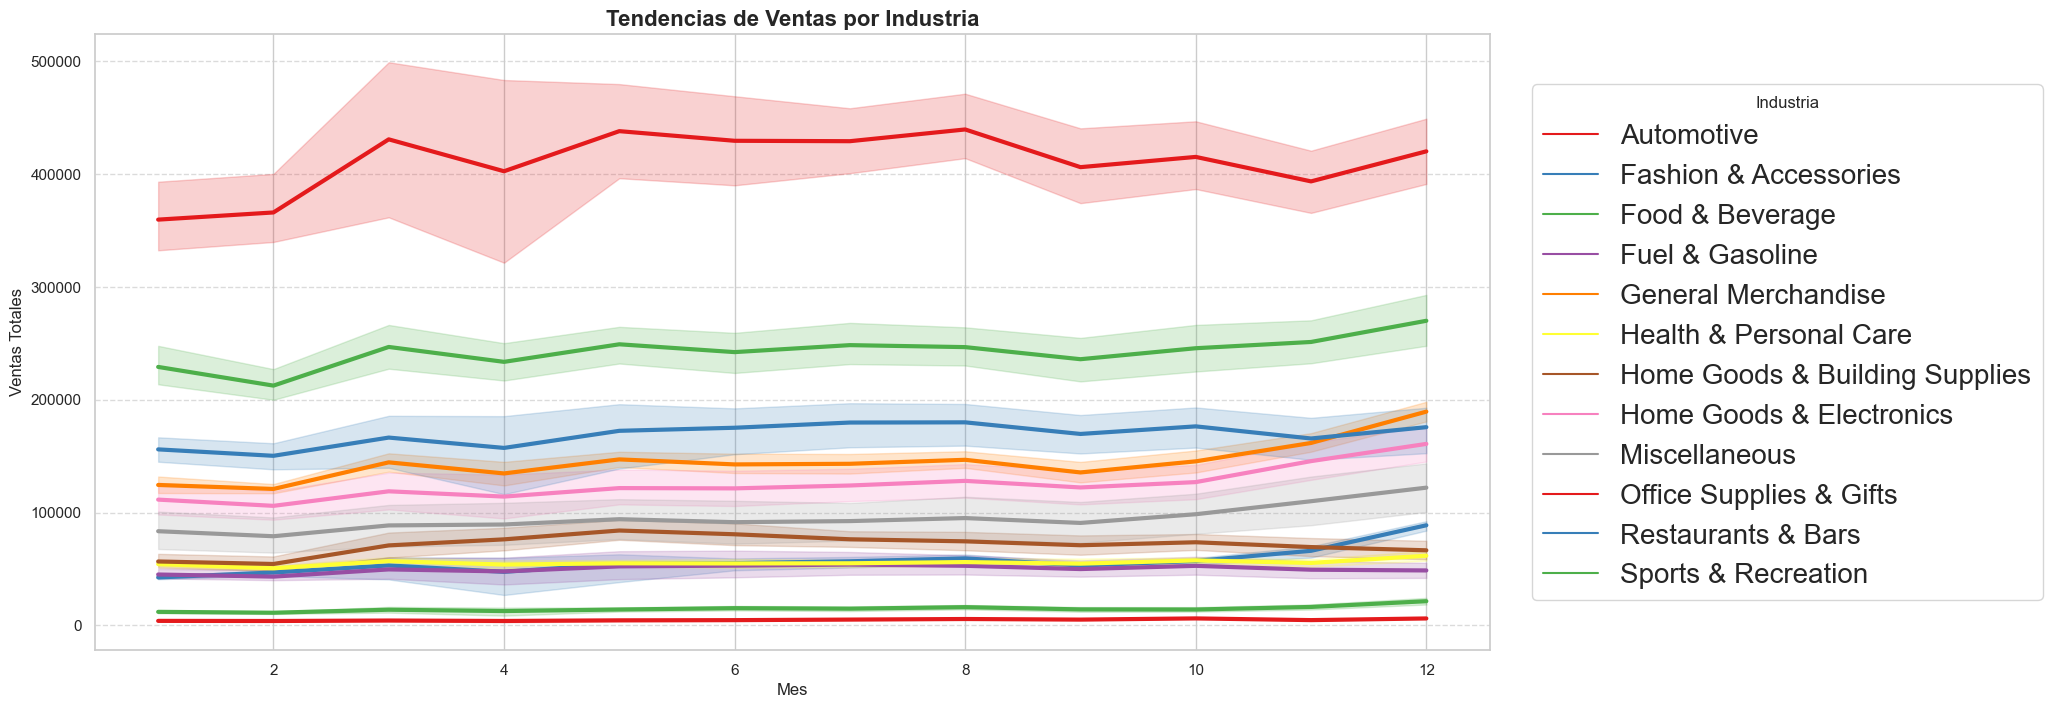

In [106]:
plt.figure(figsize=(18, 8))  # Aumentar el tamaño de la figura
sns.lineplot(data=df4, x='month', y='total_sales', hue='industry', palette='Set1', linewidth=3)

# Títulos y etiquetas
plt.title('Tendencias de Ventas por Industria', fontsize=16, fontweight='bold')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Ventas Totales', fontsize=12)

# Leyenda en una pantalla a la derecha
plt.legend(title='Industria', fontsize=20, loc='center left', bbox_to_anchor=(1.02, 0.5))  # Cambiar el título de la leyenda y la ubicación

# Cuadrícula
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

En este gráfico podemos sacar varias concluiones:

+ Las industrias Automotive y Food and Beverage son las que más ventas producen de todas las industrias

+ Existe un repunte de las ventas en la mayoría de industrias en los meses  3 (antes de verano) y 11 (pre-navidad). 
  Estas tendencias pueden estar relacionadas con factores estacionales. 

## 4. ¿Qué top 3 empresas han vendido más de 10.000 millones de dólares de media?

In [121]:
query= """
    SELECT kind_of_business,avg (sales) as media_ventas
    from df 
    group by kind_of_business
    having media_ventas > 10000
    order by media_ventas DESC
    limit 3;"""

In [122]:
df5=pd.read_sql(sql=text(query),con=database.connect())

In [123]:
df5

,kind_of_business,media_ventas
0,Motor vehicle and parts dealers,93148.211538
1,Automobile and other motor vehicle dealers,85325.358974
2,Automobile dealers,79418.891026


## 5. ¿Cuál es el porcentaje de contribución de cada negocio en la industria del automóvil en el 2022?

In [128]:
query= """
    WITH automotive_sales AS (
    SELECT
        kind_of_business,
        SUM(sales) AS total_sales
    FROM
        df
    WHERE
        industry = 'Automotive' AND
        year = 2022  
    GROUP BY
        kind_of_business
),
total_sales_automotive AS (
    SELECT
        SUM(sales) AS total_sales_automotive
    FROM
        df
    WHERE
        industry = 'Automotive' AND
        year = 2022
)
SELECT
    kind_of_business,
    ROUND((total_sales / total_sales_automotive.total_sales_automotive) * 100, 2) AS contribution_percentage
FROM
    automotive_sales
CROSS JOIN
    total_sales_automotive;"""

In [129]:
df6=pd.read_sql(sql=text(query),con=database.connect())

In [130]:
df6

,kind_of_business,contribution_percentage
0,Automobile and other motor vehicle dealers,24.96
1,Automobile dealers,22.83
2,"Automotive parts, acc., and tire stores",2.21
3,Motor vehicle and parts dealers,27.17
4,New car dealers,19.97
5,Used car dealers,2.86


### 🚩Agrupa las ventas por tipo de negocio dentro de la industria automotriz para el año 2022.

In [ ]:
WITH automotive_sales AS (
    SELECT
        kind_of_business,
        SUM(sales) AS total_sales
    FROM
        df
    WHERE
        industry = 'Automotive' AND
        year = 2022  
    GROUP BY
        kind_of_business
)


### 🚩Calcula las ventas totales de toda la industria automotriz para el año 2022

In [ ]:
total_sales_automotive AS (
    SELECT
        SUM(sales) AS total_sales_automotive
    FROM
        df
    WHERE
        industry = 'Automotive' AND
        year = 2022
)


### 🚩Se calculan los porcentajes de contribución de cada uno a las ventas totales de la industria automotriz.

In [ ]:
SELECT
    kind_of_business,
    ROUND((total_sales / total_sales_automotive.total_sales_automotive) * 100, 2) AS contribution_percentage
FROM
    automotive_sales
CROSS JOIN
    total_sales_automotive;


## 6. ¿Cuáles son las tasas de crecimiento interanual de cada sector por año?

In [19]:
query= """
    SELECT
    year,
    industry,
    (sales - LAG(sales) OVER (PARTITION BY industry ORDER BY year)) / LAG(sales) OVER (PARTITION BY industry ORDER BY year) * 100 AS growth_rate
FROM
    df
ORDER BY
    industry, year;"""

In [20]:
df7=pd.read_sql(sql=text(query),con=database.connect())

In [21]:
df7

,year,industry,growth_rate
0,2010,Automotive,NaN
1,2010,Automotive,-10.635653
2,2010,Automotive,-5.394247
3,2010,Automotive,-12.160239
4,2010,Automotive,-86.156339
...,...,...,...
9043,2022,Sports & Recreation,-78.755160
9044,2022,Sports & Recreation,1908.520179
9045,2022,Sports & Recreation,-42.382972
9046,2022,Sports & Recreation,-55.993283


###  🚩Vamos a explicar con más detalle la parte más difícil de la query.

+ La función "LAG" permite acceder al valor de una fila previa en el mismo conjunto de filas .

+ OVER (PARTITION BY industry ORDER By year) indica que la función LAG debe considerar las filas dentro de cada grupo de industria ("Partition BY industry") y ordenarlas por año ("ORDER BY year")

+ Por lo tanto, LAG(sales) devolverá el valor de sales de la fila anterior para cada industria ordenada por año.

+ Se calcula la diferencia en ventas con respecto al año anterior (sales- LAG(sales))


## 7 ¿Cuáles son las ventas totales anuales de las tiendas de ropa de mujer y de las tiendas de ropa de hombre?

In [24]:
query= """
    SELECT 
    year,
    sum(CASE WHEN kind_of_business = 'Women''s clothing stores' THEN sales ELSE 0 END) as women_sales,
    sum(CASE WHEN kind_of_business = 'Men''s clothing stores' THEN sales ELSE 0 END) as men_sales
FROM
    df
GROUP BY 
    year;"""

In [32]:
df8=pd.read_sql(sql=text(query),con=database.connect())
df8

,year,women_sales,men_sales
0,2010,37690.0,7285.0
1,2011,40048.0,7860.0
2,2012,41794.0,8272.0
3,2013,41586.0,8838.0
4,2014,41175.0,9226.0
5,2015,40471.0,9361.0
6,2016,40065.0,9272.0
7,2017,39212.0,9296.0
8,2018,39891.0,9288.0
9,2019,38382.0,9304.0


### 8.  ¿Cuál es la relación anual entre las ventas totales de las tiendas de ropa de mujer y las ventas totales de las tiendas de ropa de hombre?

In [41]:
query = """
SELECT 
    year, 
    women_sales / men_sales AS Women_to_Men_ratio
FROM (
    SELECT 
        year,
        SUM(CASE WHEN kind_of_business = 'Women''s clothing stores' THEN sales ELSE 0 END) AS women_sales,
        SUM(CASE WHEN kind_of_business = 'Men''s clothing stores' THEN sales ELSE 0 END) AS men_sales
    FROM 
        df
    GROUP BY 
        year
) AS sales_comparison
ORDER BY 
    year;
"""

In [42]:
df9=pd.read_sql(sql=text(query),con=database.connect())
df9

,year,Women_to_Men_ratio
0,2010,5.173644
1,2011,5.095165
2,2012,5.052466
3,2013,4.705363
4,2014,4.462931
5,2015,4.323363
6,2016,4.321074
7,2017,4.218158
8,2018,4.294897
9,2019,4.125322
